# Assessment for Advanced Data Science

## Christian Cabrera, Carl Henrik Ek and Neil D. Lawrence

### 29th October 2021



Welcome to the course assessment for the Advanced Data Science unit. In this assessment you will build a prediction system for UK house prices. 

Your prediction system will be based on data from the UK Price Paid data available [here](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). By combining this data with the UK Office for National Statistics data on the latitude/longitude of postcodes (available [here](https://www.getthedata.com/open-postcode-geo)) you will have a record of house prices and their approximate latitude/longitude. Due to the size of these data you will use a relational database to handle them.  

To make predictions of the house price you will augment your data with information obtained from Open Street Map: an open license source of mapping information. You will use the techniques you have learnt in the course to indentify and incorporate useful features for house price prediction.



Alongside your implementation you will provide a short repository overview describing how you have implemented the different parts of the project and where you have placed those parts in your code repository. You will submit your code alongside a version of this notebook that will allow your examiner to understand and reconstruct the thinking behind your analysis. This notebook is structured to help you in creating that description and allow you to understand how we will allocate the marks. You should make use of the Fynesse framework (<https://github.com/lawrennd/fynesse_template>) for structuring your code. 

Remember the notebook you create should *tell a story*, any code that is not critical to that story can safely be placed into the associated analysis library and imported for use (structured as given in the Fynesse template)

The maximum total mark for this assessment is 20. That mark is split into Three Questions below, each worth 5 marks each. Then a final 5 marks will be given for the quality, structure and reusability of the code and analysis you produce giving 20 marks in total.


### Useful Links

You may find some of the following links useful when building your system.

University instuctions on Security and Privacy with AWS.

https://help.uis.cam.ac.uk/service/network-services/hosting-services/AWS/aws-security-privacy

Security Rules in AWS 

https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/USER_VPC.Scenarios.html#USER_VPC.Scenario4

### Installing Your Library

One artefact to be included in your submission is a python library structured according to the "Access, Assess, Address" standard for data science solutions. You will submit this library alongside your code. Use the cell below to perform the necessary installation instructions for your library.

You should base your module on the template repository given by the Fynesse template repository. That should make it `pip` installable as below. 



In [1]:
#%pip install git+https://github.com/printlnHi/ukpricepaid.git
%cd /Users/marcus/Dropbox/CSTII/ADS/ukpricepaid
from fynesse import access, address, assess
%cd ./notebooks

from fynesse import access, address, assess

/Users/marcus/Dropbox/CSTII/ADS/ukpricepaid
/Users/marcus/Dropbox/CSTII/ADS/ukpricepaid/notebooks


Your own library should be installed in the line above, then you can import it as usual (where you can either replace `fynesse` with the name you've given your analysis module or you can leave the name as `fynesse` as you prefer).

## Question 1. Accessing a Database of House Prices, Latitudes and Longitudes

The UK price paid data for housing in dates back to 1995 and contains millions of transactions. The size of the data makes it unwieldy to manipulate directly in python frameworks such as `pandas`. As a result we will host the data in a *relational database*. 

Using the following ideas.

1. A cloud hosted database (such as MariaDB hosted on the AWS RDS service).
2. The SQL language wrapped in appropriately structured python code.
3. Joining of two databases.

You will construct a database containing tables that contain all house prices, latitudes and longitudes from the UK house price data base since 1995.

You will likely find the following resources helpful.

1. Lecture 1, 2 and 3.
2. Lab class 1 and 2.
3. The UK Price Paid data for houses: <https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads>
4. The UK ONS Data base of postcode latitude and longitudes:  <https://www.getthedata.com/open-postcode-geo>

Below we provide codeboxes and hints to help you develop your answer.

*The main knowledge you need to do a first pass through this question will have been taught by the end of Lab Session 2 (11th November 2021). You will likely want to review your answer as part of **refactoring** your code  and analysis pipeline shortly before hand in.*

*5 Marks*

### Task A

Set up the database. You'll need to set up a database on AWS. You were guided in how to do this in the lab sessions. You should be able to use the same database instance you created in the lab, or you can delete that and start with a fresh instance. You'll remember from the lab that the database requires credentials (username, password) to access. It's good practice to store those credentials *outside* the notebook so you don't accidentally share them by e.g. checking code into a repository. 
  
Call the database you use for this assessment `property_prices`.
  

In [2]:
#database_details = {"url": "database-mwh38-assessment.cgrre17yxw11.eu-west-2.rds.amazonaws.com","port": 3306}
database_details = {"url": "localhost", 
                    "port": 3306}

In [3]:
import yaml
with open("credentials.yaml") as file:
  credentials = yaml.safe_load(file)

In [4]:
conn = access.create_connection_and_maybe_create_database_if_missing(user=credentials["username"], 
                         password=credentials["password"], 
                         host=database_details["url"],
                         port=database_details["port"],
                         database="property_prices",
                         )

### Task B

Create a database table called `pp_data` containing all the UK Price Paid data from the [gov.uk site](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). You'll need to prepare a new table to receive the data and upload the UK Price Paid data to your database instance. The total data is over 3 gigabytes in size. We suggest that rather than downloading the full data in CSV format, you use the fact that they have split the data into years and into different parts per year. For example, the first part of the data for 2018 is stored at <http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018-part1.csv>. Each of these files is less than 100MB and can be downloaded very quickly to local disk, then uploaded using 


```
LOCAL DATA LOAD INFILE 'filename' INTO TABLE `table_name`
FIELDS TERMINATED BY ',' 
LINES STARTING BY '' TERMINATED BY '\n';
```
*Note* this command should be wrapped and placed in an appropriately structured python module. 

Each 'data part' should be downloadable from the `gov.uk` site and uploadable to your database instance in a couple of seconds. By looping across the years and different parts, you should be able to robustly upload this large data set to your database instance in a matter of minutes. 

You may find the following schema useful in creation of your database:

```
--
-- Table structure for table `pp_data`
--
DROP TABLE IF EXISTS `pp_data`;
CREATE TABLE IF NOT EXISTS `pp_data` (
  `transaction_unique_identifier` tinytext COLLATE utf8_bin NOT NULL,
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `primary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `secondary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `street` tinytext COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `ppd_category_type` varchar(2) COLLATE utf8_bin NOT NULL,
  `record_status` varchar(2) COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;
```
This schema is written by Dale Potter and can be found on Github here: <https://github.com/dalepotter/uk_property_price_data/blob/master/create_db.sql>

You may also find it helpful to set up the following indexes in the database

```
--
-- Indexes for table `pp_data`
--
ALTER TABLE `pp_data`
ADD PRIMARY KEY (`db_id`);
MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;
CREATE INDEX `pp.postcode` USING HASH
  ON `pp_data`
    (postcode);
CREATE INDEX `pp.date` USING HASH
  ON `pp_data` 
    (date_of_transfer);
```


In the box below, briefly describe what the schema is doing and why we will find it useful to create the indexes we have for the table we've created.

When querying `pp_data`, we'll be selecting rows based on `date_of_transfer` (for looking at certain historical windows) and `postcode` (for joining with `postcode_data`). Creating indicies massively speeds up these queries. For example, observe the speed difference in counting the number of entries on the ides march, 2018 before and after indicies are created. As we can see below, it takes 2 minutes without indicies vs <1s with indicies when running on colab and rds and 6.87s vs 11.2ms when running on a local jupyter and database. 

I have also added an index on property_type as I wish to make queries on transactions with property type other

In [5]:
DATA_DIR = "data" #The location where data files are to be found / downloaded to before being inserted into the database

In [21]:
access.create_pricepaid_table(conn)

()

In [22]:
access.load_pricepaid_data(conn,DATA_DIR,years=range(1995,2023))

Loading data/pp-1995.csv into pp_data
Loading data/pp-1996.csv into pp_data
Loading data/pp-1997.csv into pp_data
Loading data/pp-1998.csv into pp_data
Loading data/pp-1999.csv into pp_data
Loading data/pp-2000.csv into pp_data
Loading data/pp-2001.csv into pp_data
Loading data/pp-2002.csv into pp_data
Loading data/pp-2003.csv into pp_data
Loading data/pp-2004.csv into pp_data
Loading data/pp-2005.csv into pp_data
Loading data/pp-2006.csv into pp_data
Loading data/pp-2007.csv into pp_data
Loading data/pp-2008.csv into pp_data
Loading data/pp-2009.csv into pp_data
Loading data/pp-2010.csv into pp_data
Loading data/pp-2011.csv into pp_data
Loading data/pp-2012.csv into pp_data
Loading data/pp-2013.csv into pp_data
Loading data/pp-2014.csv into pp_data
Loading data/pp-2015.csv into pp_data
Loading data/pp-2016.csv into pp_data
Loading data/pp-2017.csv into pp_data
Loading data/pp-2018.csv into pp_data
Loading data/pp-2019.csv into pp_data
Loading data/pp-2020.csv into pp_data
Loading data

In [23]:
!wc -l $DATA_DIR/*.csv

 2610679 data/open_postcode_geo.csv
  796852 data/pp-1995.csv
  965042 data/pp-1996.csv
 1094154 data/pp-1997.csv
 1050231 data/pp-1998.csv
 1194593 data/pp-1999.csv
 1129067 data/pp-2000.csv
 1245558 data/pp-2001.csv
 1351464 data/pp-2002.csv
 1235143 data/pp-2003.csv
 1231633 data/pp-2004.csv
 1061180 data/pp-2005.csv
 1325786 data/pp-2006.csv
 1272054 data/pp-2007.csv
  649509 data/pp-2008.csv
  625162 data/pp-2009.csv
  663176 data/pp-2010.csv
  661085 data/pp-2011.csv
  668762 data/pp-2012.csv
  810809 data/pp-2013.csv
  984551 data/pp-2014.csv
 1010302 data/pp-2015.csv
 1045196 data/pp-2016.csv
 1065445 data/pp-2017.csv
 1034589 data/pp-2018.csv
 1005528 data/pp-2019.csv
  868650 data/pp-2020.csv
 1139524 data/pp-2021.csv
  456603 data/pp-2022.csv
 30252327 total


In [25]:
%%time
print(access.execute(conn,'SELECT COUNT(*) FROM pp_data WHERE date_of_transfer = "2018-03-15"'))

((2477,),)
CPU times: user 2.06 ms, sys: 2.43 ms, total: 4.49 ms
Wall time: 6.87 s


In [6]:
access.create_pricepaid_indicies(conn)

()

In [7]:
%%time
print(access.execute(conn,'SELECT COUNT(*) FROM pp_data WHERE date_of_transfer = "2018-03-15"'))

((2477,),)
CPU times: user 1.4 ms, sys: 2.09 ms, total: 3.49 ms
Wall time: 11.2 ms


In [24]:
%%time
pp_summary = assess.summarise_table(conn,"pp_data",["price"],["YEAR(date_of_transfer)","property_type","new_build_flag","tenure_type","county"])

total_rows: ((27641648,),)
price summary statistics:
 max/avg/min:5.94e+08/2.14e+5/1 stddev:8.51e+05
YEAR(date_of_transfer) group counts:
 ((1995, 796852), (1996, 965042), (1997, 1094154), (1998, 1050231), (1999, 1194593), (2000, 1129067), (2001, 1245558), (2002, 1351464), (2003, 1235143), (2004, 1231633), (2005, 1061180), (2006, 1325786), (2007, 1272054), (2008, 649509), (2009, 625162), (2010, 663176), (2011, 661085), (2012, 668762), (2013, 810809), (2014, 984551), (2015, 1010302), (2016, 1045196), (2017, 1065445), (2018, 1034589), (2019, 1005528), (2020, 868650), (2021, 1139524), (2022, 456603))
property_type group counts:
 (('D', 6377737), ('F', 4963954), ('O', 414280), ('S', 7572933), ('T', 8312744))
new_build_flag group counts:
 (('N', 24805640), ('Y', 2836008))
tenure_type group counts:
 (('F', 21142445), ('L', 6498670), ('U', 533))
county group counts:
 (('AVON', 16424), ('BATH AND NORTH EAST SOMERSET', 86727), ('BEDFORD', 39552), ('BEDFORDSHIRE', 129229), ('BERKSHIRE', 9245), (

### Task C

Create a database table called `postcode_data` containing the ONS Postcode information. <GetTheData.com> has organised data derived from the UK Office for National Statistics into a convenient CSV file. You can find details [here](https://www.getthedata.com/open-postcode-geo).


The data you need can be found at this url: <https://www.getthedata.com/downloads/open_postcode_geo.csv.zip>. It will need to be unzipped before use.

You may find the following schema useful for the postcode data (developed by Christian and Neil)

```
USE `property_prices`;
--
-- Table structure for table `postcode_data`
--
DROP TABLE IF EXISTS `postcode_data`;
CREATE TABLE IF NOT EXISTS `postcode_data` (
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `status` enum('live','terminated') NOT NULL,
  `usertype` enum('small', 'large') NOT NULL,
  `easting` int unsigned,
  `northing` int unsigned,
  `positional_quality_indicator` int NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `lattitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `postcode_no_space` tinytext COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_seven` varchar(7) COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_eight` varchar(8) COLLATE utf8_bin NOT NULL,
  `postcode_area` varchar(2) COLLATE utf8_bin NOT NULL,
  `postcode_district` varchar(4) COLLATE utf8_bin NOT NULL,
  `postcode_sector` varchar(6) COLLATE utf8_bin NOT NULL,
  `outcode` varchar(4) COLLATE utf8_bin NOT NULL,
  `incode` varchar(3)  COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin;
```

And again you'll want to set up indices for your table.

```
ALTER TABLE `postcode_data`
ADD PRIMARY KEY (`db_id`);
MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;
CREATE INDEX `po.postcode` USING HASH
  ON `postcode_data`
    (postcode);
```

And you can load the CSV file into the table in one "INFILE".

```
LOAD DATA LOCAL INFILE 'open_postcode_geo.csv' INTO TABLE `postcode_data`
FIELDS TERMINATED BY ',' 
LINES STARTING BY '' TERMINATED BY '\n';
```

In [14]:
access.create_postcode_table(conn)

In [15]:
#You need to already have the csv file in your DIR (if using colab, upload directly as the upload() interactive has an implict size limit)
access.load_file(conn,"postcode_data",f"{DATA_DIR}/open_postcode_geo.csv")

()

In [16]:
postcode_summary = assess.summarise_table(conn,"postcode_data",["lattitude","longitude","easting","northing","positional_quality_indicator"],["country","status","usertype"])

total_rows: ((27641648,),)
lattitude summary statistics:
 min/avg/max:0e-8/52.2/60.8 stddev:4.94
longitude summary statistics:
 min/avg/max:-7.65/-1.54/1.76 stddev:1.43
easting summary statistics:
 min/avg/max:5.49e+04/4.32e+5/6.56e+05 stddev:9.72e+04
northing summary statistics:
 min/avg/max:8.13e+03/3.07e+5/1.21e+06 stddev:1.75e+05
positional_quality_indicator summary statistics:
 min/avg/max:1/1.90/9 stddev:2.24
country group counts:
 (('England', 2230317), ('Wales', 140261), ('Scotland', 227042), ('Channel Islands', 6995), ('Isle of Man', 6064))
status group counts:
 (('live', 1735811), ('terminated', 874868))
usertype group counts:
 (('small', 1891013), ('large', 719666))


We know the entirety of the UK lies about the equator.
Thus, a minimimum lattitude of 0 indicates some postcodes have some invalid coordinates, likely dummy (0,0) values. Also, the Channel Islands, the Isle of Man and Scotland are not included in pricepaid data. In Task D below we will assess and clean postcode_data.

### Task D 

These data can now be joined to form a new table that contains house price paid and latitude longitude of the house. We could create a new table that contains all this information. However, the computation of that table will take some time because of the size of the two existing tables in the join. 

Instead, we're going to exploit the nature of the task. To build our prediction model, we're going to use the prices for a particular region in a given time period. This means we can select that region and time period and build the joined data only from the relevent rows from the two tables. This will save time on the join.

Whether this is a good idea or not in a live system will depend on how often these predictions are required. If it's very often, it would likely be better to store the entired database joined, because the one-off cost for that join is amortised across all the future predictions. If only a few predictions are required (like in our lab class) then doing that join on the fly might be better. In that case you can make use of an  *inner join* for this data set creation.

```
USE `property_prices`;
--
-- Table structure for table `prices_coordinates_data`
--
DROP TABLE IF EXISTS `prices_coordinates_data`;
CREATE TABLE IF NOT EXISTS `prices_coordinates_data` (
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `lattitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;


```



We can now perform a join around Selwyn College to look at all transactions in 2020. The coordinates of Selwyn are 52.2011° N, 0.1056° E

In [58]:
inner_join(conn, access.bbox(access.selwyn_coords, 0.1), date_bound = ("2020-01-01","2020-12-31"))

,price,date_of_transfer,postcode,property_type,new_build_flag,tenure_type,locality,town_city,district,county,country,latitude,longitude,geometry
0,413000,2020-02-21,CB1 1BB,F,N,L,,CAMBRIDGE,CAMBRIDGE,CAMBRIDGESHIRE,England,52.20245900,0.13275200,POINT (0.13275 52.20246)
1,8300000,2020-12-22,CB1 1BH,O,N,F,,CAMBRIDGE,CAMBRIDGE,CAMBRIDGESHIRE,England,52.20348900,0.13179000,POINT (0.13179 52.20349)
2,230000,2020-11-24,CB1 1DJ,O,N,F,,CAMBRIDGE,CAMBRIDGE,CAMBRIDGESHIRE,England,52.20571800,0.13302500,POINT (0.13303 52.20572)
3,367500,2020-08-20,CB1 1DP,F,N,F,,CAMBRIDGE,CAMBRIDGE,CAMBRIDGESHIRE,England,52.20564000,0.13087000,POINT (0.13087 52.20564)
4,225000,2020-03-20,CB1 1DR,F,N,L,,CAMBRIDGE,CAMBRIDGE,CAMBRIDGESHIRE,England,52.20551600,0.13228300,POINT (0.13228 52.20552)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407,431000,2020-07-27,CB5 8QD,S,N,F,,CAMBRIDGE,CAMBRIDGE,CAMBRIDGESHIRE,England,52.21510600,0.15553400,POINT (0.15553 52.21511)
1408,425000,2020-01-09,CB5 8QD,D,N,F,,CAMBRIDGE,CAMBRIDGE,CAMBRIDGESHIRE,England,52.21510600,0.15553400,POINT (0.15553 52.21511)
1409,488000,2020-05-07,CB5 8TH,F,N,L,,CAMBRIDGE,CAMBRIDGE,CAMBRIDGESHIRE,England,52.20903700,0.13598000,POINT (0.13598 52.20904)
1410,265000,2020-10-16,CB5 8TH,F,N,L,,CAMBRIDGE,CAMBRIDGE,CAMBRIDGESHIRE,England,52.20903700,0.13598000,POINT (0.13598 52.20904)


### Cleaning postcode_data

Previously in task C we identified that anomalous coordinates existing by summarising the `postcode_data` table and looking at the summary statistics for lattitude and longitude. We observed postcodes for countries other than England and Wales. A minimimum lattitude of 0 alerted us to the existence of anomalous coordinates. We can count the number of coordinates with a latitude of 0 and confirming they all are (0,0). 

In [6]:
print(access.execute(conn, "SELECT COUNT(*) FROM postcode_data WHERE lattitude=0"))
print(access.execute(conn, "SELECT COUNT(*) FROM postcode_data WHERE lattitude=0 AND longitude=0"))

((20848,),)
((20848,),)


By performing an inner join with a bounding box centered on (0,0) we can confirmed that no postcodes with (0,0) values are present in the price paid data

In [7]:
print(len(access.inner_join(conn, bbox=(-0.05,0.05,-0.05,0.05), limit=5)))

0


I clean `postcode_data` to remove null values and postcodes outside of England & Wales, after backing up the table to `postcode_data_uncleaned`

In [20]:
access.clean_postcode_data(conn, backup_table = "postcode_data_uncleaned")

In [21]:
postcode_summary = assess.summarise_table(conn,"postcode_data",["lattitude","longitude","easting","northing","positional_quality_indicator"],["country","status","usertype"])

total_rows: ((27641648,),)
lattitude summary statistics:
 min/avg/max:49.9/52.3/55.8 stddev:1.13
longitude summary statistics:
 min/avg/max:-6.35/-1.35/1.76 stddev:1.32
easting summary statistics:
 min/avg/max:8.79e+04/4.45e+5/6.56e+05 stddev:9.08e+04
northing summary statistics:
 min/avg/max:8.13e+03/2.68e+5/6.56e+05 stddev:1.25e+05
positional_quality_indicator summary statistics:
 min/avg/max:1/1.83/8 stddev:2.13
country group counts:
 (('England', 2223623), ('Wales', 139604))
status group counts:
 (('live', 1564228), ('terminated', 798999))
usertype group counts:
 (('small', 1696682), ('large', 666545))


We can now see that only postcodes in England and Wales remain and that the min/max lattitudes and longitudes form a bbox from 49.9 to 55.8 degrees North and 6.35 degrees West to 1.76 degrees East. Inspecting a map of the world tells us this is roughly correct. The vast majority of the English / Welsh population lives on the English or Welsh mainland. By looking at the [Extreme Points of the UK](https://en.wikipedia.org/wiki/List_of_extreme_points_of_the_United_Kingdom#Great_Britain) we see
- The southmost point of the England & Wales mainland is Lizard Point **49.9591**, -5.2065 in England
- The northmost point of the England & Wales mainland is Marshall Meadows Bay **55.8111**, -2.0343 in England
- The westernmost point of the England & Wales mainland is Dr Syntax's Head in England 50.066667, **-5.716667**
- The easternmost point of the England & Wales mainland is Ness Point 52.483333, **1.766667** in England

We can count the points in the cleaned postcode_data which are outside of the bounding box, noting they are all in England

In [9]:
outside_mainland = access.inner_join(conn,bbox=access.mainland_bbox,invert_bbox=True)

In [19]:
from collections import Counter
Counter(outside_mainland["county"])

Counter({'ISLES OF SCILLY': 613, 'CORNWALL': 6})

From https://www.gov.uk/guidance/about-the-price-paid-data#explanations-of-column-headers-in-the-ppd
D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other 
Note that: 
- we only record the above categories to describe property type, we do not separately identify bungalows 
- end-of-terrace properties are included in the Terraced category above 
- ‘Other’ is only valid where the transaction relates to a property type that is not covered by existing values, for example where a property comprises more than one large parcel of land

## Question 2. Accessing OpenStreetMap and Assessing the Available Features

In question 3 you will be given the task of constructing a prediction system for property price levels at a given location. We expect that knowledge of the local region around the property should be helpful in making those price predictions. To evaluate this we will now look at [OpenStreetMap](https://www.openstreetmap.org) as a data source.

The tasks below will guide you in accessing and assessing the OpenStreetMap data. The code you write will eventually be assimilated in your python module, but documentation of what you've included and why should remain in the notebook below. 

Accessing OpenStreetMap through its API can be done using the python library `osmx`. Using what you have learned about the `osmx` interface in the lectures, write general code for downloading points of interest and other relevant information that you believe may be useful for predicting house prices. Remembering the perspectives we've taken on *data science as debugging*, the remarks we've made when discussing *the data crisis* of the importance of reusability in data analysis, and the techniques we've explored in the labsessions for visualising features and exploring their correlation use the notebook to document your assessment of the OpenStreetMap data as a potential source of data.

The knowledge you need to do a first pass through this question will have been taught by end of lab session three (16th November 2021). You will likely want to review your answer as part of *refactoring* your code and analysis pipeline shortly before hand in.

You should write reusable code that allows you to explore the characteristics of different points of interest. Looking ahead to question 3 you'll want to incorporate these points of interest in your prediction code.

*5 marks*


In [ ]:
# Use this cell and cells below for summarising your analysis and documenting your decision making.

### Assessing transactions and price across the UK
Firstly I wish to understand the geographic distribution of transactions and transaction prices. As there are too many transactions (27 million) to work with in jupyter, I sample ~1 in 100 transactions. I decided whether to include a transaction in a sample by calling `RAND` on it's `DB_id` and checking if this is below a threshold. I have decided this is appropriate as the more simple method of checking `DB_id`'s congruence under some modulus seemed to give strange aliasing affects for certain moduli and bounding boxes.

In [11]:
import matplotlib.pyplot as plt
import osmnx as ox
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

In [14]:
one_in_10_sample = sample

In [8]:
sample = access.inner_join(conn,one_in=100)

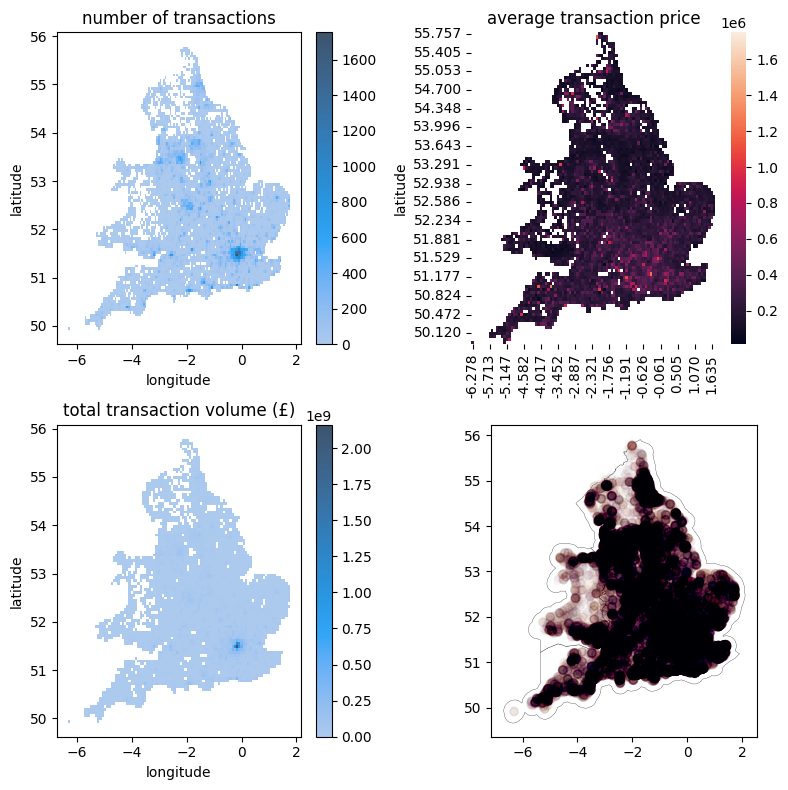

In [9]:
assess.plot_transactions_and_prices_geographically(sample, bins_across=100, alpha=0.01, geocodes=["England","Wales"])

Looking at the first two charts, as expected, we can see that the greatest transaction frequency and average transaction price is easily in London. We also notice greater transaction frequency around Birmingham, Manchester, Liverpool and other major cities, but not the same corresponding increase in average transaction price. The transaction volume chart confirms this as volume is the product of average price and count and the volume chart has the rest of the UK looking rather uniform compared to London. 

N.B: As we have only sampled 1% of transactions the quantities in the 'number of transactions' and 'total transaction volume' plot are 1% of the true value.

I now wish to get an understanding of how house prices trend over time. Asset growth is generally understood in terms of relative growth rather than absolute growth, so I decided to plot house prices on a log scale. I'm interested in overall trends and the trends by property type. As I have a lot of data, I will plot monthly price. If I were examining a smaller transaction set, I might need to plot price quarterly or yearly.  

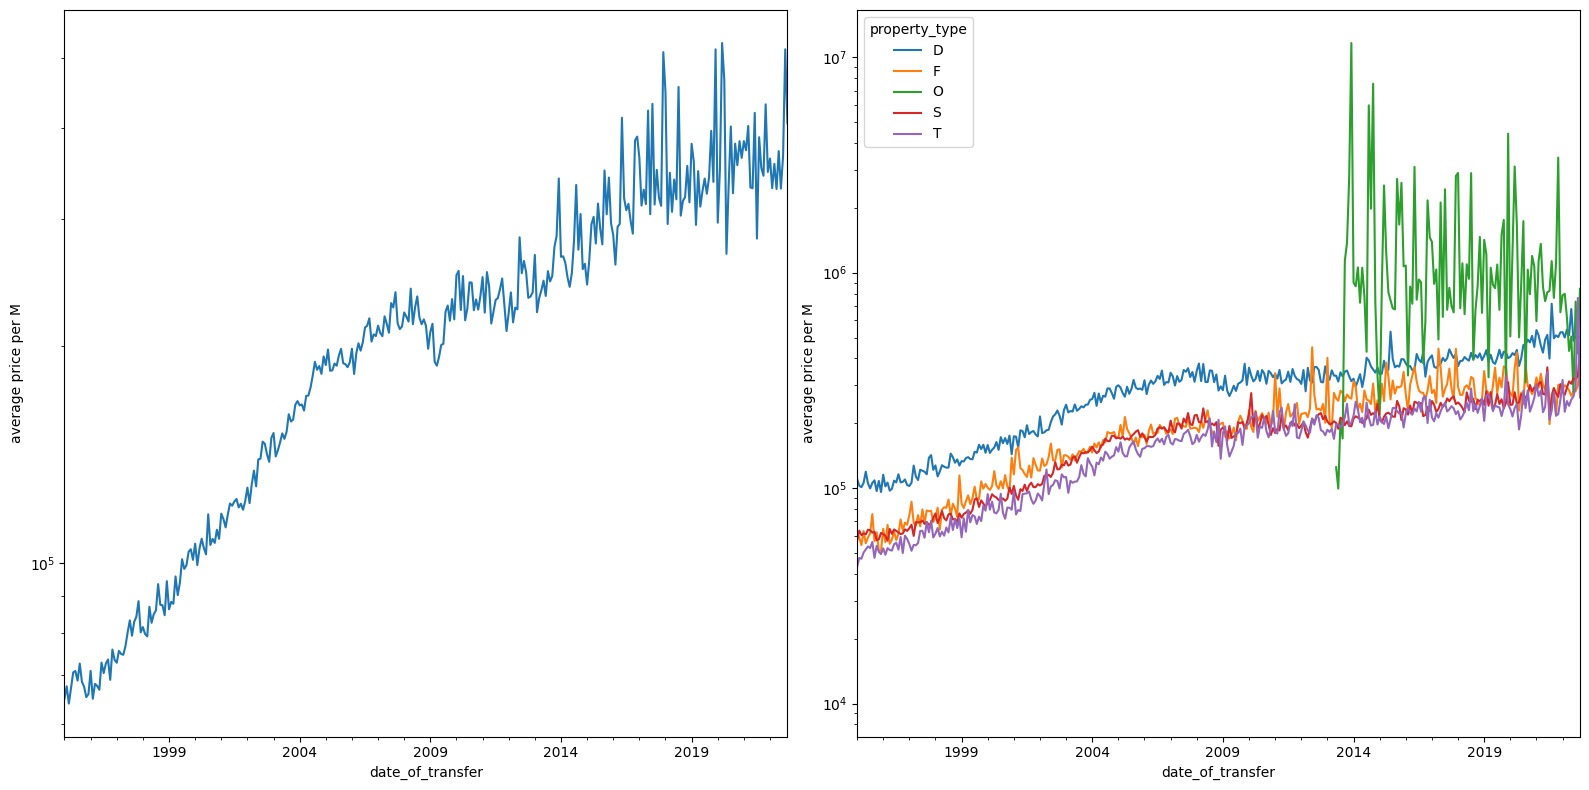

In [17]:
assess.plot_price_trends(sample, period="M")

The overall monthly house price plot shows that average log price increase linearly up to 2008, where house prices fall throughout 2008 and 2009 before growing again. After 2009, the growth in transaction price continues, althrough at a slower gradient and with far greater volatility, especially after ~2015.

Inspecting the chart broken down by property type, we notice that the "Other" category seems to have been introduced around mid-2013, and exhibits far greater volatility than other property types, and is perhaps a cause of increased volatlity. 

One possible explanation is greater volatility likely partially results from its "catch-all" or "miscellaneous" function of capturing transactions in properties that cannot be explained as a more normal type. This likely includes commercial transactions, and thus both the purpose of property sold and value relative to its purpose can be expected to be more sensitive to economic conditions, and thus fluctuate with the business cycle.

However, as demonstrated by our summary of pp_data in Q1 Task B, "Other" property_type transactions are ~1/10th - 1/20th as common as the remaining property types.

In [20]:
'''The call to summarise_time is repeated  from Q1 Task B as it plays a role in accessing the data
(checking for completeness) and assessing it (summarising the frequency of different property types). 
Here we only group on the columns which we return from our inner join'''
pp_summary = assess.summarise_table(conn,"pp_data",["price"],["YEAR(date_of_transfer)","property_type"])

total_rows: ((27641648,),)
price summary statistics:
 min/avg/max:1/2.14e+5/5.94e+08 stddev:8.51e+05
YEAR(date_of_transfer) group counts:
 ((1995, 796852), (1996, 965042), (1997, 1094154), (1998, 1050231), (1999, 1194593), (2000, 1129067), (2001, 1245558), (2002, 1351464), (2003, 1235143), (2004, 1231633), (2005, 1061180), (2006, 1325786), (2007, 1272054), (2008, 649509), (2009, 625162), (2010, 663176), (2011, 661085), (2012, 668762), (2013, 810809), (2014, 984551), (2015, 1010302), (2016, 1045196), (2017, 1065445), (2018, 1034589), (2019, 1005528), (2020, 868650), (2021, 1139524), (2022, 456603))
property_type group counts:
 (('D', 6377737), ('F', 4963954), ('O', 414280), ('S', 7572933), ('T', 8312744))


As a result, the observed volality in "Other" property_type average price may simply be due to insufficient samples. As we have added an index on property_type, we can take a sample of 1/4 of these transactions and reinspect the average price trend

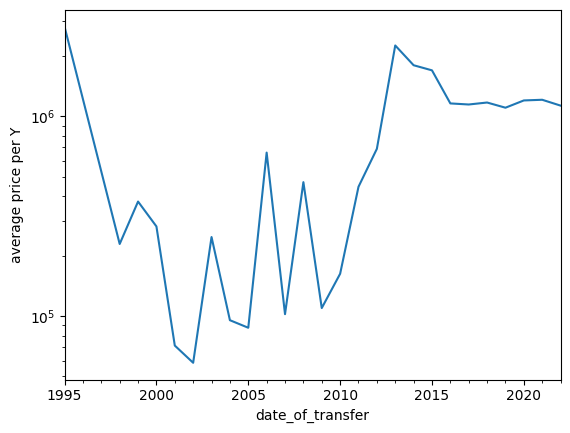

In [14]:
sample_of_other = access.inner_join(conn, property_type="O", one_in=5)
assess.plot_price_trend(sample_of_other)

This demonstrates that in fact, "Other" property_types do not have above average volatility in price, and that observed greater volality was due to small samples. It also demonstrates that the "other" property type was not introduced in ~2013, it was just exceptionally rare (as a result of 1% sampling, we expect there to be ~100 transactions of type O before the O-type transactions appear on the graph in 2013).

The trends in house prices suggest multiple possible features to capture the impact of transfer_date on price. A simple way of capturing this would be anything linear in date, such as the number of years or weeks or days since the 1st of January 1995. A more complex feature would be the average or log average price over a 30 day window or the month. This could be specific to the property_type, or overall and may be a better suited feature as time is likely a proxy for the state of the housing market, which had a direct causal link on property prices

In [17]:
def days_since_1195(transactions):
    return np.array((txs["transactions"].dt.date-datetime.date.fromisoformat("1995-01-01")).dt.days)
monthly_average_prices_by_type = sample.groupby(sample.property_type).apply(lambda df: assess.periodic_average(df, "M", "price", "date_of_transfer"))


In [19]:
monthly_average_prices_by_type

property_type  date_of_transfer
D              1995-01             110549.703390
               1995-02             102476.818182
               1995-03             101058.173077
               1995-04             105708.257812
               1995-05             119238.841060
                                       ...      
T              2022-05             257355.385714
               2022-06             266560.620915
               2022-07             294543.314465
               2022-08             763631.503268
               2022-09             263074.137931
Length: 1453, dtype: float64

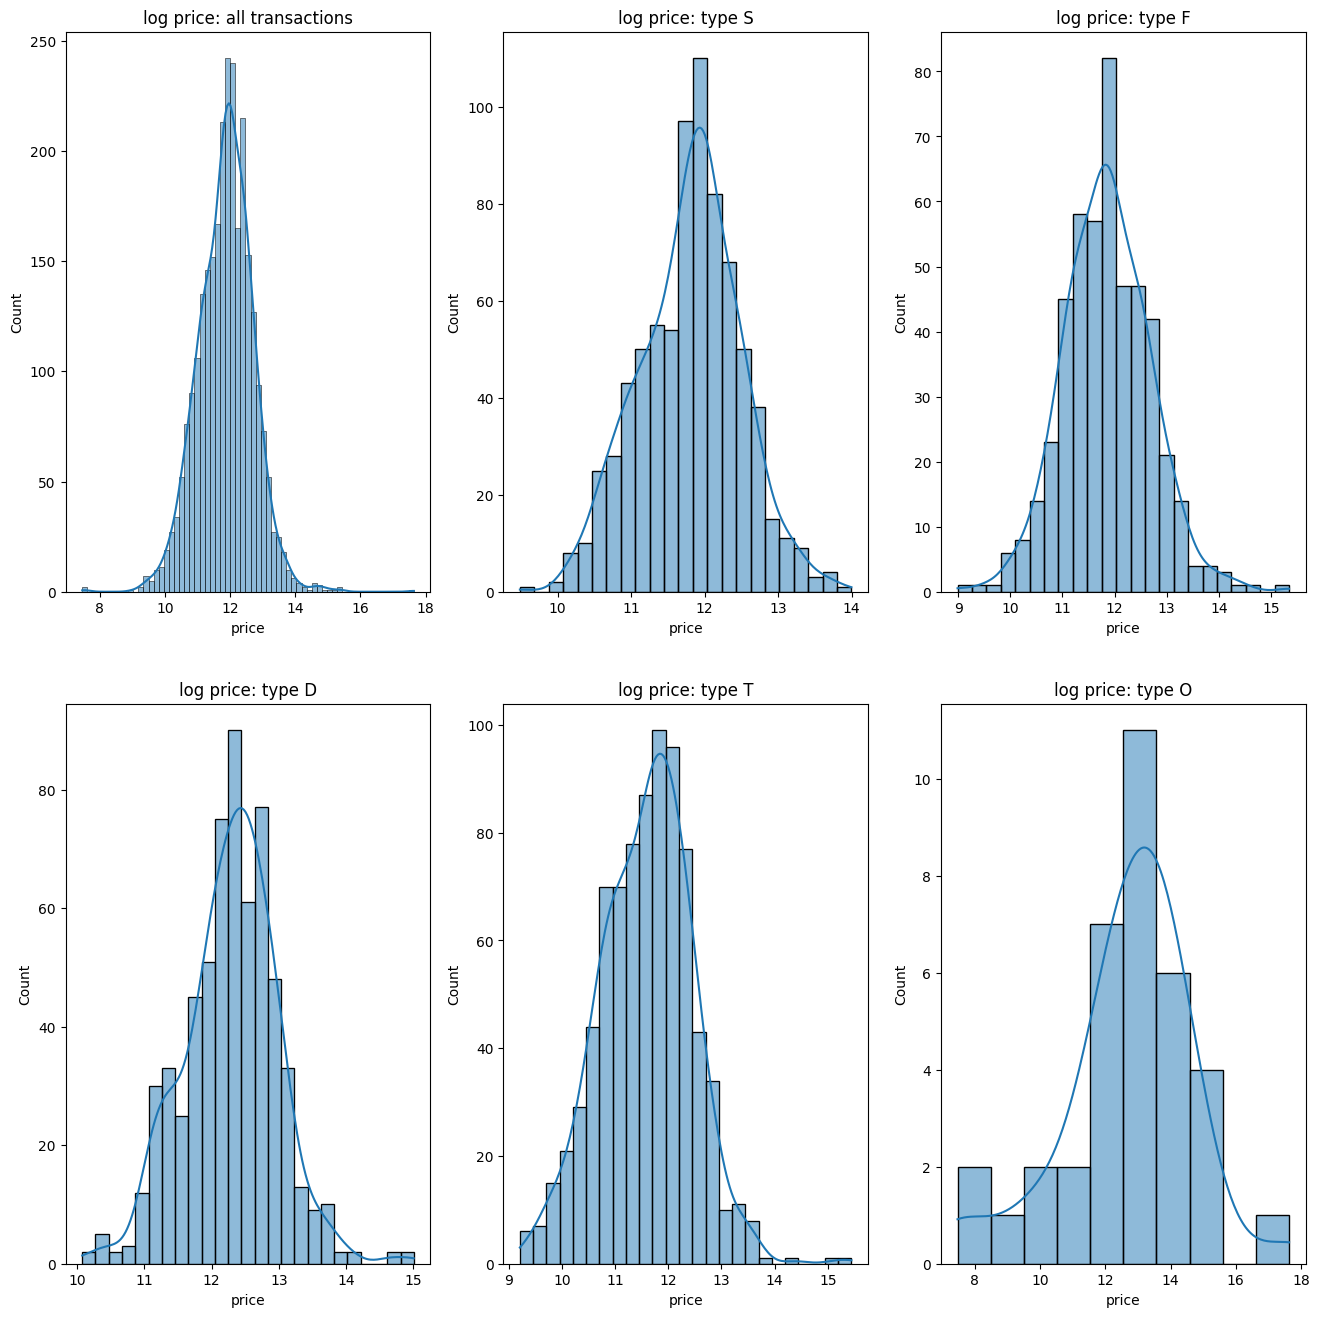

In [9]:
assess.plot_logprice_frequency(sample)

### Assessing price in local areas
I want to confirm that

In [209]:
bbox = access.km_bbox(access.example_coords["selwyn"],5,5)
txs = access.inner_join(conn,bbox)
print(f"{len(txs)} transactions")


    SELECT price, date_of_transfer, `pp_data`.postcode, property_type, new_build_flag, tenure_type, locality, town_city, district, county, country, lattitude, longitude
    FROM
        `pp_data`
    INNER JOIN
        `postcode_data`
    ON
        `pp_data`.postcode = `postcode_data`.postcode
    WHERE lattitude between 52.16441622728187 AND 52.237783772718124 AND longitude between 0.0831169916126777 and 0.12808300838732228
    
    
17058 transactions


NameError: name 'plot_edges' is not defined

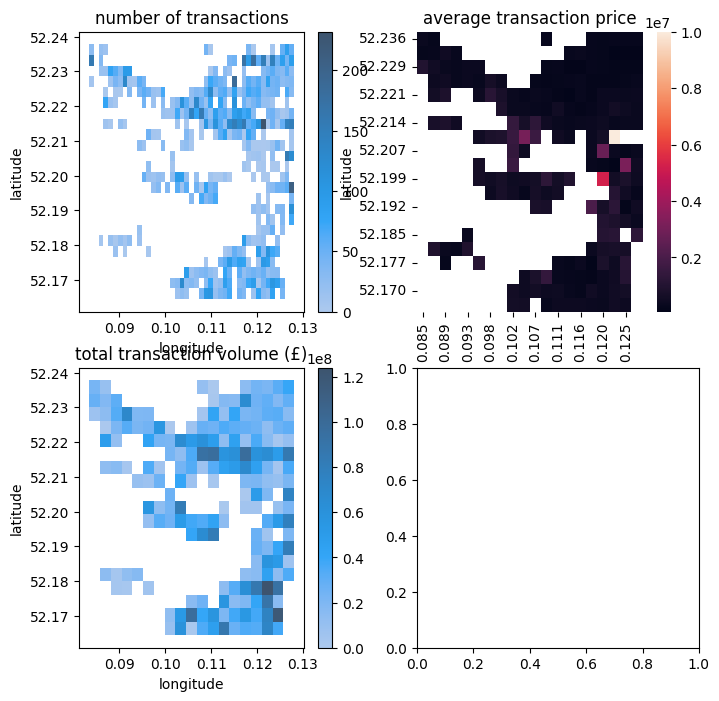

In [212]:
plot_transactions_and_prices(txs, bbox=bbox)

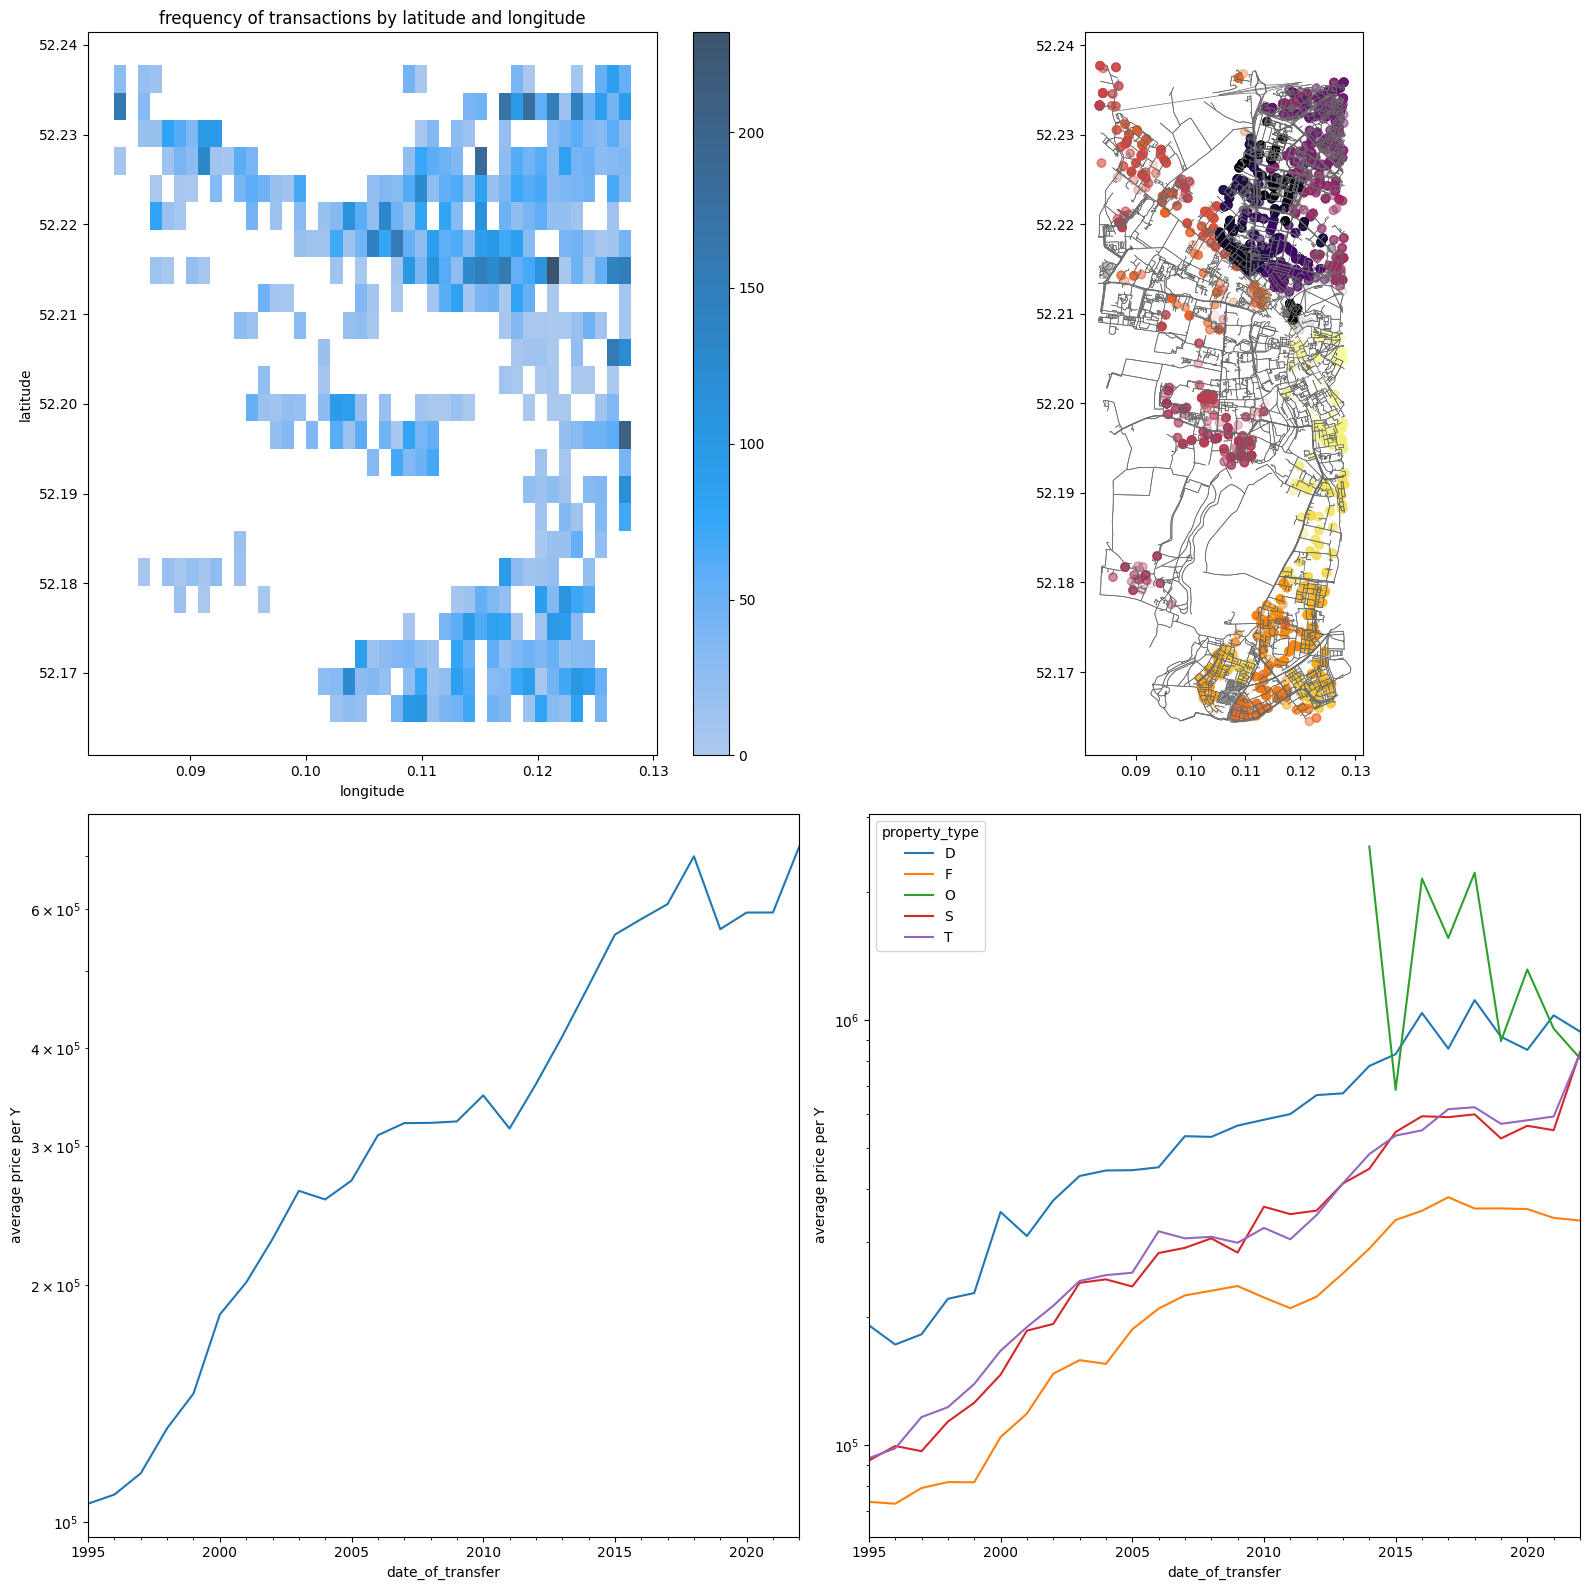

In [77]:
plot_transactions_and_price_trends(bbox, txs, edges=True)

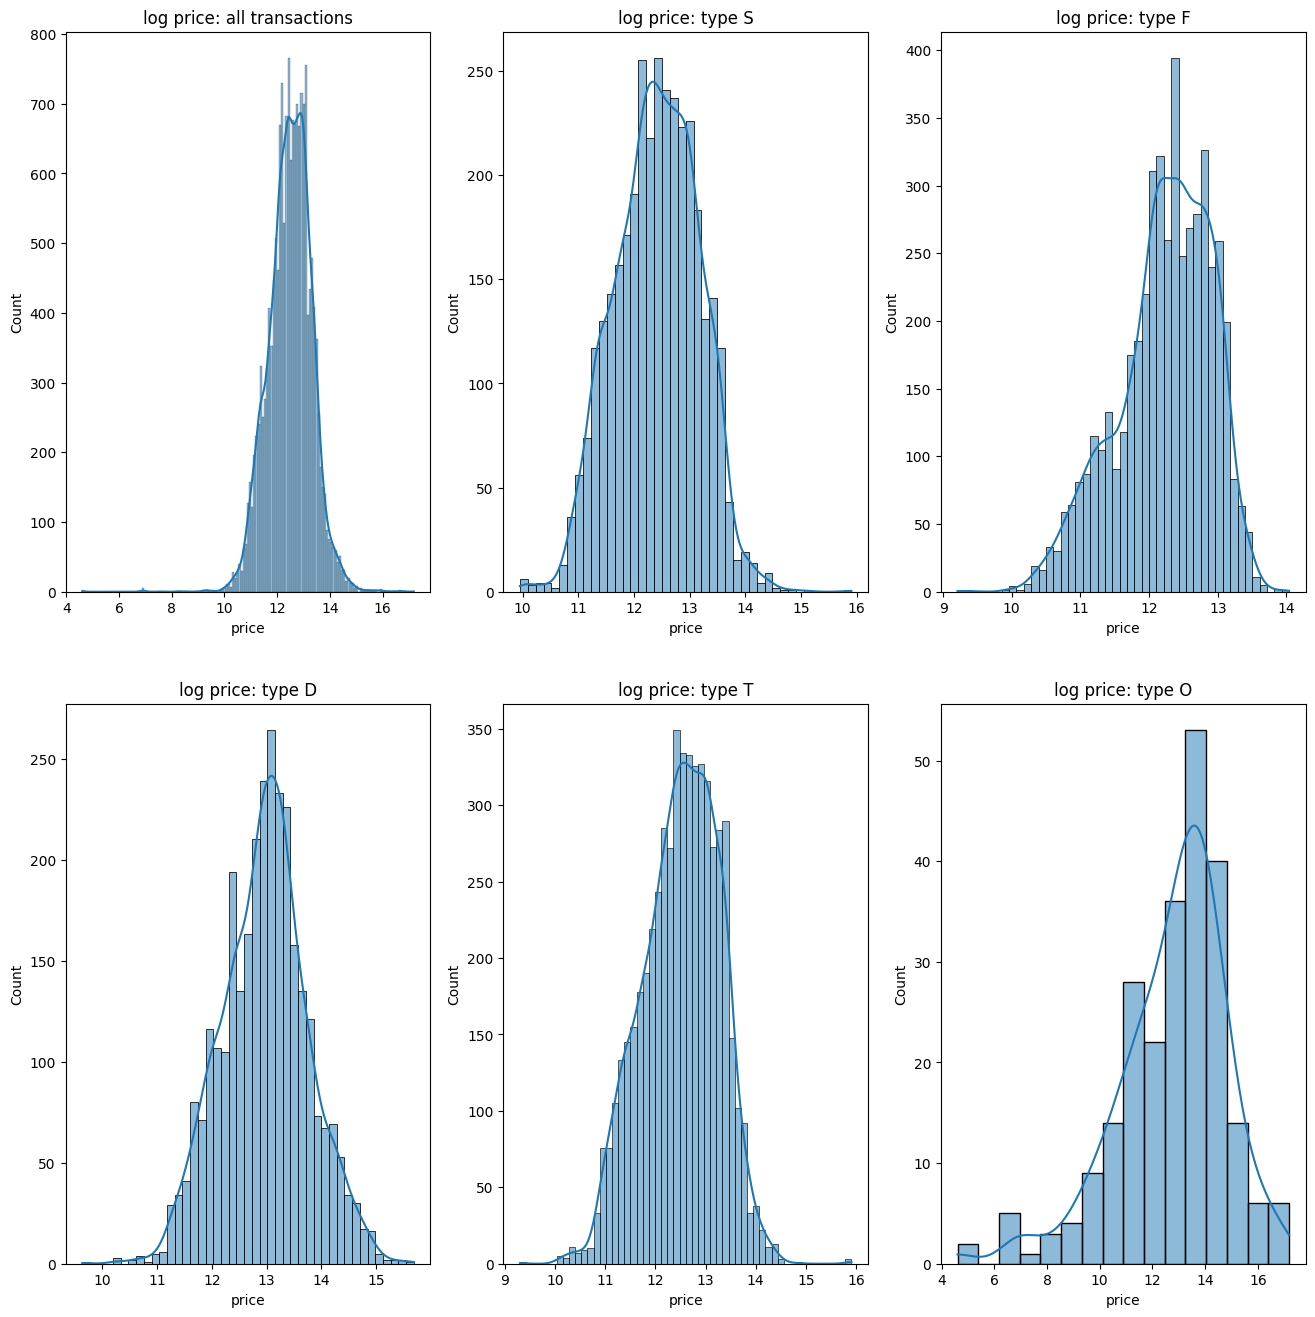

In [47]:
plot_logprices(txs)

### Anaysing POI's across the UK
I have constructed tagsets of POIs where I believe proximity to these POIs will have significant impact on house prices. In particular, I am interested in whether we have POIs of two kinds. Those that give discrimantory information between nearby houses - if I told you that 

In [5]:
amenities_of_interest = {"amenity":["bicycle_station", "boat_rental", "bus_station","brothel","casino","gambling","love_hotel","swingerclub","prison","stripclub","college","kindergarten","library","toy_library","training","school","university","place_of_worship"]}


In [27]:
import osmnx as ox

In [7]:
pois = access.collect_pois(access.mainland_bbox,amenities_of_interest)

In [28]:
pois = access.collect_pois(access.mainland_bbox,[{"tagset":"very_negative_amenities"}])
vneg.plot()

634 pois from very_negative_amenities


AttributeError: 'list' object has no attribute 'plot'

In [24]:
pois = vneg[0]["pois"]
from collections import Counter
Counter(pois["amenity"])

Counter({'casino': 199,
         'gambling': 239,
         'prison': 177,
         'brothel': 15,
         'swingerclub': 4})

### Analysing POI's locally

In [5]:
target = access.example_coords["selwyn"]
height = 3
width = 3
query_dates = ("2020-01-01","2021-12-31")
query_bbox = access.km_bbox(target,height,width)
poi_collection_specs = [{"tagset":"positive_transport_amenities", "color":"green","markersize":100,"marker":"*"},
           {"tagset":"very_negative_amenities", "color":"red","markersize":200,"marker":"x"},
                       {"tagset":"mid_distance_education_amenities", "color":"blue", "markersize": 100, "marker":"X"}]

In [33]:
poi_specs=access.collect_pois(query_bbox,poi_collection_specs)

4 pois from positive_transport_amenities
0 pois from very_negative_amenities
138 pois from mid_distance_education_amenities


In [34]:
#print("positive amenities\n", positive_transport_amenity_pois.groupby("amenity").size())
#print("very negative amenities\n",very_negative_amenity_pois.groupby("amenity").size())

In [35]:
transactions = access.inner_join(conn, query_bbox, date_bound = query_dates)
print(f"{len(transactions)} transactions in {query_bbox} between {query_dates[0]} and {query_dates[1]}")

798 transactions in (52.17175298182549, 52.2304470181745, 0.08761359329014216, 0.12358640670985784) between 2020-01-01 and 2021-12-31


(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

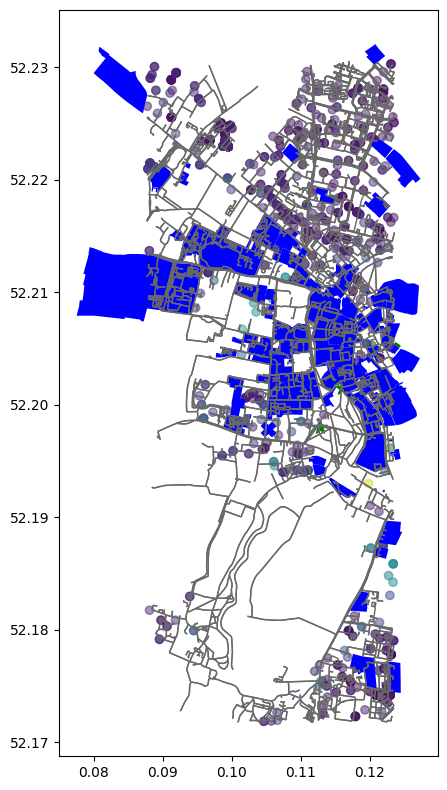

In [36]:
assess.plot_transactions_and_pois(query_bbox,transactions,poi_specs)

In [98]:
def do(a,*b,**kwargs):
    print(a)
    print(b)
    print(type(b))
    print(**kwargs)
do("hi",1,2)

hi
(1, 2)
<class 'tuple'>



In [37]:
import geopandas as gpd
features=gpd.GeoDataFrame(transactions[["price","latitude","longitude"]])

In [38]:
for poi_spec in poi_specs:
    pois = poi_spec["pois"]
    distances = assess.get_smallest_distances_2D(transactions, pois)
    closest = distances.map(lambda iterable: min(iterable,default=0))            
    features[f"closest_{poi_spec['tagset']}"] = closest
features

,price,latitude,longitude,closest_positive_transport_amenities,closest_very_negative_amenities,closest_mid_distance_education_amenities
0,18500,52.20743100,0.12284700,210.409046,0,14.592026
1,725000,52.20512600,0.12301500,46.247491,0,20.155771
2,630000,52.20512600,0.12301500,46.247491,0,20.155771
3,640000,52.20512600,0.12301500,46.247491,0,20.155771
4,6000000,52.19613900,0.12298000,756.144021,0,39.518074
...,...,...,...,...,...,...
793,205432,52.21112100,0.11811900,716.442605,0,35.335807
794,560000,52.21112100,0.11811900,716.442605,0,35.335807
795,500000,52.20914300,0.12010400,462.292710,0,15.434549
796,600000,52.21030100,0.11923700,599.617274,0,33.953258


In [39]:
corr_matrix = features.corr()

/var/folders/rc/kdg81bxs3gdbtn3qxq2hdy980000gn/T/ipykernel_37885/2351203604.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = features.corr()


<AxesSubplot: >

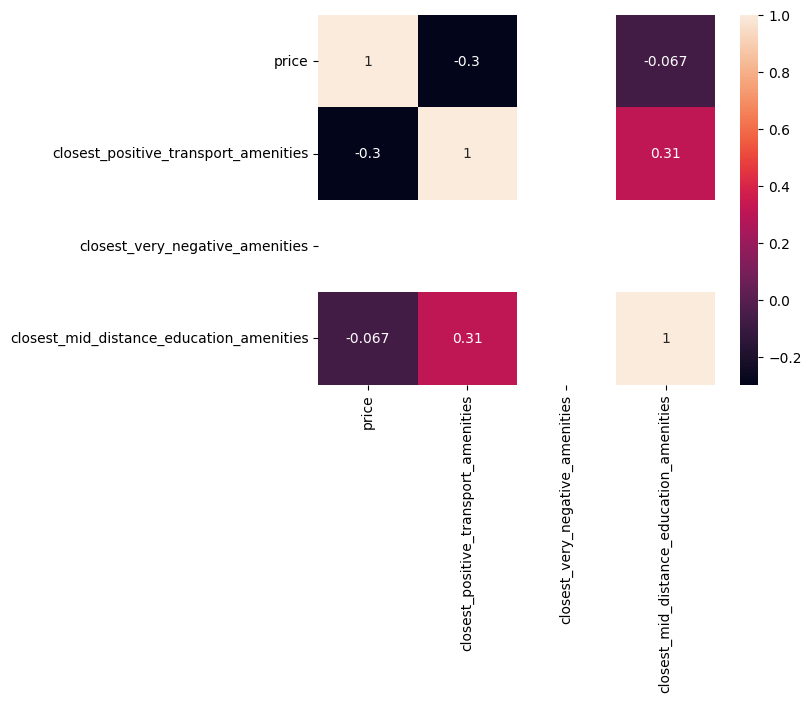

In [40]:
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(corr_matrix,annot=True)

## Question 3. Addressing a Property Price Prediction Question

For your final tick, we will be asking you to make house price predictions for a given location, date and property type in the UK. You will provide a function that takes input a latitude and longitude as well as the `property_type` (either type" of property (either `F` - flat, `S` - semidetached, `D` - detached, `T` - terraced or `O` other). Create this function in the `address.py` file, for example in the form,

```
def predict_price(latitude, longitude, date, property_type):
    """Price prediction for UK housing."""
    pass
```

We suggest that you use the following approach when building your prediction. 

1. Select a bounding box around the housing location in latitude and longitude.
2. Select a data range around the prediction date. 
3. Use the data ecosystem you have build above to build a training set from the relevant time period and location in the UK. Include appropriate features from OSM to improve the prediction.
4. Train a linear model on the data set you have created.
5. Validate the quality of the model.
6. Provide a prediction of the price from the model, warning appropriately if your validation indicates the quality of the model is poor.

The knowledge you need to do a first pass through this question will have been taught by end of lab session four (25th November 2021). You will likely want to review your answer as part of *refactoring* your code shortly before hand in.



In [140]:
def old_predict_price(latitude, longitude, date, property_type, output=0):
    target = (latitude,longitude)
    
    assert(access.in_bbox(target,access.mainland_bbox))
    assert(property_type in access.property_types)
    
    def get_count_for_params(height,width,delta):
        query_dates = (str(date-delta),str(date+delta))
        query_bbox = access.km_bbox(target,height,width)
        transactions = access.inner_join(conn, query_bbox, date_bound = query_dates)    
        allowed_types = transactions[transactions["property_type"]==property_type] #TODO: have a list types passed in
        print(f"{len(allowed_types)} allowed type / {len(transactions)} transactions")
        return allowed_types
    
    
    height = 1
    width = 1
    delta = pd.Timedelta(days=365*4)
    query_dates = (str(date-delta),str(date+delta))
    query_bbox = access.km_bbox(target,height,width)  
    txs = None
    
    while height<10:
        txs = get_count_for_params(height,width,delta)
        if len(txs) < 20:
            height*=1.25
            width*=1.25
            print(f"growing bounding box by 25% both ways. height={height:.3g}km width={width:.3g}km")
        else:
            break
            
    
    poi_collection_specs = [
    {"tagset":"positive_transport_amenities", "color":"green","markersize":100,"marker":"*"},
    {"tagset":"very_negative_amenities", "color":"red","markersize":200,"marker":"x"}]
    
    poi_specs=access.collect_pois_from_collection_spec(query_bbox,poi_collection_specs)
    
    ys = txs["price"]
    xs=gpd.GeoDataFrame(txs[["latitude","longitude","date_of_transfer"]])
    
    dec_to_float = lambda dec_array : np.array(list(map(float,dec_array)))
    lats,longs = dec_to_float(np.asarray(txs["latitude"])),dec_to_float(np.asarray(txs["longitude"]))
    lat_devs,long_devs = lats-latitude, longs-longitude
    days_dev = np.array((txs["date_of_transfer"].dt.date-date).dt.days)
    
    design_cols = [np.ones(len(txs)),lat_devs,long_devs,days_dev]
    design_pred = [1,0,0,0]
    
    for poi_spec in poi_specs:
        pois = poi_spec["pois"]
        distances = assess.get_smallest_distances_2D(txs, pois)
        distance_pred = assess.get_smallest_distances_2D(gpd.GeoSeries([Point(latitude,longitude)],crs="EPSG:4326"), pois)
        closest = distances.map(lambda iterable: min(iterable,default=0))
        closest_pred = min(distance_pred[0],default=0)
        design_cols.append(np.array(closest))
        design_pred.append(closest_pred)
        
            
    if output > 2:
        assess.plot_transactions_and_pois(query_bbox, txs, poi_specs)
        
    
    design = np.concatenate(tuple(col.reshape(-1,1) for col in design_cols),axis=1)
    
    m = sm.OLS(ys,design)
    m_results = m.fit()
    
    if output > 1:
        print(m_results.summary())
        print(m_results.params)
    
    y_pred = m_results.get_prediction(design_pred).summary_frame(alpha=0.05).iloc[0]
    
    if output > 0:
        print(f'prediction {y_pred["mean"]:.4g} 95% CI {y_pred["obs_ci_lower"]:.4g} {y_pred["obs_ci_upper"]:.4g}')
    return y_pred

In [40]:
def train_model(y,X):
    model = sm.OLS(y,X)
    return model.fit()

In [27]:
def grow_bounding_box(conn, target, date, time_delta, initial_width=1, initial_height=1, max_growth=10, transaction_requirement=100):
    growth = 1
    date_bound = (str(date-delta),str(date+delta))
    transactions = None
    while growth <= max_growth:
        bbox = access.km_bbox(target, initial_width*growth, initial_height*growth)
        transactions = access.inner_join(conn, bbox, date_bound = date_bound)
        if len(transactions) >= transaction_requirement:
            print(f"grew bounding box to {initial_width * growth} km wide and {initial_height * growth} km high.\n Found {len(transactions)} transactions")
            return (bbox, transactions)
        else:
            growth = (growth * 1.5) // 0.5 * 0.5
    print(f"WARNING: grew bounding box to {initial_width * growth} km wide and {initial_height * growth} km high.\n Only found {len(transactions)} transactions, less than requirement of {transaciton_requirement}")

In [69]:
def dec_to_float(dec_array):
    return np.array(list(map(float,dec_array)))

In [56]:
import datetime
import geopandas as gpd
import statsmodels.api as sm
import numpy as np
from shapely.geometry import Point
import pandas as pd
from sklearn import model_selection
from sklearn import metrics


latitude, longitude = access.example_coords["selwyn"]
date = prediction_date
property_type = "D"
output = 0

if True:
#def predict_price(latitude, longitude, date, property_type, output=0):
    target = (latitude,longitude)
    
    assert(access.in_bbox(target,access.mainland_bbox))
    assert(property_type in access.property_types)
    
    bbox, transactions = grow_bounding_box(conn, target, date, pd.Timedelta(days=365*4))
    
    poi_collection_specs = [
    {"tagset":"positive_transport_amenities", "color":"green","markersize":100,"marker":"*"},
    {"tagset":"very_negative_amenities", "color":"red","markersize":200,"marker":"x"}]
    
    poi_specs=access.collect_pois_from_collection_spec(query_bbox,poi_collection_specs)
    
    xs=gpd.GeoDataFrame(txs[["latitude","longitude","date_of_transfer"]])
    
    lats,longs = dec_to_float(np.asarray(txs["latitude"])),dec_to_float(np.asarray(txs["longitude"]))
    lat_devs,long_devs = lats-latitude, longs-longitude
    days_dev = np.array((txs["date_of_transfer"].dt.date-date).dt.days)
    
    design_cols = [lat_devs,long_devs,days_dev] + [np.array((txs.property_type==ptype),dtype=int) for ptype in access.property_types]
    design_pred = [0,0,0]+[property_type==ptype for ptype in access.property_types]
    
    for poi_spec in poi_specs:
        pois = poi_spec["pois"]
        if len(pois) == 0:
            print(f"no POIs for {poi_spec['tagset']}")
            continue
        distances = assess.get_smallest_distances_2D(txs, pois)
        distance_pred = assess.get_smallest_distances_2D(gpd.GeoSeries([Point(latitude,longitude)],crs="EPSG:4326"), pois)
        closest = distances.map(lambda iterable: min(iterable,default=0))
        closest_pred = min(distance_pred[0],default=0)
        design_cols.append(np.array(closest))
        design_pred.append(closest_pred)
        
            
    if output > 2:
        assess.plot_transactions_and_pois(query_bbox, txs, poi_specs)
        
    X = np.concatenate(tuple(col.reshape(-1,1) for col in design_cols),axis=1)
    y = np.log(txs.price)
    
    n_splits = 5
    kf = model_selection.KFold(n_splits=n_splits,shuffle=True,random_state=0)
    
    cross_MAE = []
    cross_MSE = []
    for train_index, test_index in kf.split(txs):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        m_results = train_model(y, X)
        y_pred = m_results.predict(X_test)
        cross_MAE.append(metrics.mean_absolute_error(y_test,y_pred))
        cross_MSE.append(metrics.mean_squared_error(y_test,y_pred))
    print(f"{n_splits}-fold cross validation:\n model MAE {np.mean(cross_MAE):.4f}±{np.std(cross_MAE,ddof=1):.4f}\n model MSE {np.mean(cross_MSE):.4f}±{np.std(cross_MSE,ddof=1):.4f}")
    
        
    m_results = train_model(np.log(txs.price),design)
    
    if output > 1:
        print(m_results.summary())
        print(m_results.params)
    
    y_pred = np.exp(m_results.get_prediction(design_pred).summary_frame(alpha=0.05).iloc[0])
    
    print(y_pred)
    #return y_pred


    SELECT price, date_of_transfer, `pp_data`.postcode, property_type, new_build_flag, tenure_type, locality, town_city, district, county, country, lattitude, longitude
    FROM
        `pp_data`
    INNER JOIN
        `postcode_data`
    ON
        `pp_data`.postcode = `postcode_data`.postcode
    WHERE lattitude between 52.193763245456374 AND 52.20843675454362 AND longitude between 0.10110339832253554 and 0.11009660167746446 AND DATE(date_of_transfer) between '2016-01-02' and '2023-12-31'
    
    
grew bounding box to 1 km wide and 1 km high.
 Found 152 transactions
0 pois from positive_transport_amenities
0 pois from very_negative_amenities
no POIs for positive_transport_amenities
no POIs for very_negative_amenities
5-fold cross validation:
 model MAE 0.3241±0.0833
 model MSE 0.2065±0.1567
mean             1.727647e+06
mean_se          1.103928e+00
mean_ci_lower    1.420951e+06
mean_ci_upper    2.100540e+06
obs_ci_lower     6.709692e+05
obs_ci_upper     4.448437e+06
Name: 0, dtype

In [39]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True,random_state=0)
kf.get_n_splits(design)
for train_index, test_index in kf.split(txs):
    X_train, X_test = design[train_index], design[test_index]
    y_train, y_test = transactions.price[train_index], transactions.price[test_index]

TRAIN: [  0   1   2   3   4   5   6   9  10  11  12  13  14  15  17  18  19  20
  21  22  23  25  27  28  29  30  31  32  34  35  36  38  39  41  42  43
  46  47  48  49  50  52  53  55  56  57  58  59  60  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  84  85  86  87
  88  89  90  91  92  93  94  96  97  99 100 103 104 105 106 107 110 111
 112 114 115 116 117 118 119 120 121 123 124 126 129 130 131 132 134 137
 138 139 140 141 142 143 144 145 146 147 148 150 151] TEST: [  7   8  16  24  26  33  37  40  44  45  51  54  61  62  63  83  95  98
 101 102 108 109 113 122 125 127 128 133 135 136 149]
TRAIN: [  0   1   3   4   5   6   7   8   9  11  12  13  14  15  16  17  19  20
  21  23  24  25  26  28  29  31  32  33  34  35  36  37  38  39  40  41
  42  44  45  46  47  48  49  50  51  52  53  54  55  57  58  61  62  63
  64  65  67  68  70  72  74  75  77  78  79  80  81  82  83  86  87  88
  90  92  95  96  97  98  99 101 102 103 105 106 108 109 110 111 112 

In [ ]:
def test_traingroups(df, k=5):
    rng = np.random.default_rng()
    indicies = np.array(df.index)
    rng.shuffle(indicies)
    return np.array_split(indicies,k)

In [176]:
rng = np.random.default_rng(seed = 0)
indicies = np.array(txs.index)
rng.shuffle(indicies)
test_groups = np.array_split(indicies,5)
test_groups

[array([ 74,  42,  84,  90, 111, 107, 109,  94, 123, 132, 142,  75, 150,
         68, 114, 136,   5,  80,  16, 119,  53,  48, 126,  64, 100, 105,
         13, 131,  72, 138, 102]),
 array([116,  54, 149,   1, 125,   2, 124,  11,  39,  37,  91, 134, 133,
         23,  44, 141,  52,  38,  36,  98,  71,  20,   9,  34,  10,  27,
         50, 144,  99,  87,  25]),
 array([ 43,  88,   8, 147, 122,  22,  19, 128,  93, 129,  92,  85,   4,
         55, 146,  17,  83,   3, 110, 135,  15, 103,  30,  66,  35,  89,
         81, 139,  28,  82]),
 array([ 18,   6,  67,  65,  97,  24, 118,  57,  21, 108, 117, 106,  47,
          0,  60,  70,  62,  45,  86,  63,  26,  51, 101, 112,  49, 130,
        148,  41,  40,  96]),
 array([137,  61,  12,  79, 143,  32,  56,  46,  58,  14,  73, 140, 145,
        115,  31, 104,  77,  76,   7, 151,  69, 113, 127, 121,  78, 120,
         59,  29,  33,  95])]

In [165]:
np.split(txs.index,5)
rng

ValueError: array split does not result in an equal division

In [9]:
prediction_date = datetime.date.fromisoformat("2020-01-01")

In [157]:
predict_price(*access.example_coords["selwyn"], prediction_date,  "D", output=2)

0 pois from positive_transport_amenities
0 pois from very_negative_amenities
no POIs for positive_transport_amenities
no POIs for very_negative_amenities
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     16.37
Date:                Thu, 01 Dec 2022   Prob (F-statistic):           9.52e-16
Time:                        14:12:10   Log-Likelihood:                -96.214
No. Observations:                 152   AIC:                             208.4
Df Residuals:                     144   BIC:                             232.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|  

mean             1.727647e+06
mean_se          1.103928e+00
mean_ci_lower    1.420951e+06
mean_ci_upper    2.100540e+06
obs_ci_lower     6.709692e+05
obs_ci_upper     4.448437e+06
Name: 0, dtype: float64

0 pois from positive_transport_amenities
0 pois from very_negative_amenities
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     21.27
Date:                Thu, 01 Dec 2022   Prob (F-statistic):           3.25e-26
Time:                        14:08:37   Log-Likelihood:                -513.81
No. Observations:                 750   AIC:                             1044.
Df Residuals:                     742   BIC:                             1081.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

/Users/marcus/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


mean             166786.389971
mean_se               1.033733
mean_ci_lower    156269.501235
mean_ci_upper    178011.062041
obs_ci_lower      64520.620643
obs_ci_upper     431144.331878
Name: 0, dtype: float64

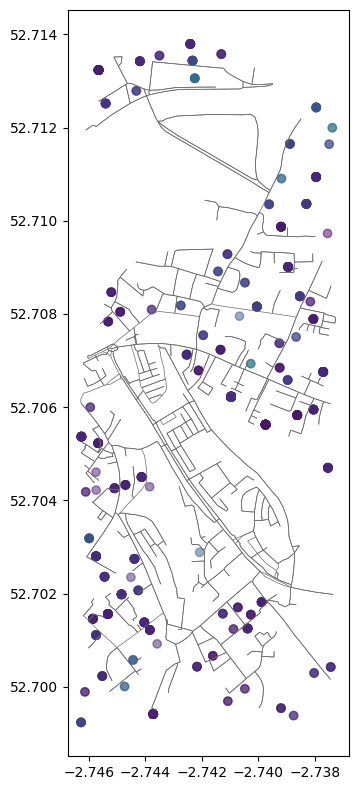

In [144]:
#Seaside apartment - after all-types
predict_price(52.7064, -2.7418, prediction_date, "F", output=3)

0 pois from positive_transport_amenities
0 pois from very_negative_amenities
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     34.81
Date:                Thu, 01 Dec 2022   Prob (F-statistic):           4.42e-42
Time:                        13:58:38   Log-Likelihood:                -9815.2
No. Observations:                 750   AIC:                         1.965e+04
Df Residuals:                     742   BIC:                         1.968e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

/Users/marcus/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


mean             181484.285028
mean_se            8070.438415
mean_ci_lower    165640.672722
mean_ci_upper    197327.897334
obs_ci_lower     -49541.691377
obs_ci_upper     412510.261433
Name: 0, dtype: float64

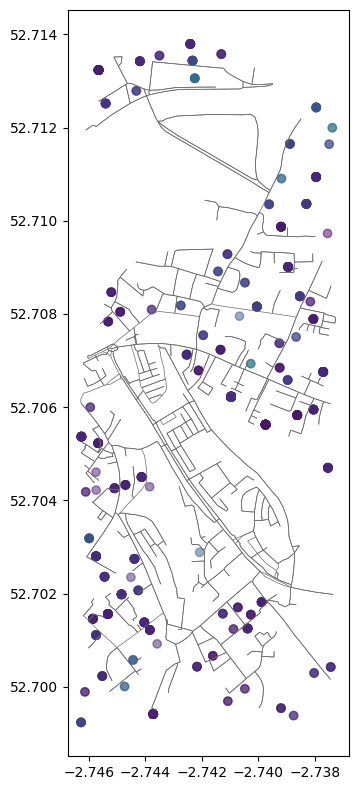

In [139]:
#Seaside apartment - after all-types without log
predict_price(52.7064, -2.7418, prediction_date, "F", output=3)

280 allowed type / 750 transactions
0 pois from positive_transport_amenities
0 pois from very_negative_amenities
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.270
Date:                Thu, 01 Dec 2022   Prob (F-statistic):             0.0807
Time:                        14:01:06   Log-Likelihood:                -3496.4
No. Observations:                 280   AIC:                             7001.
Df Residuals:                     276   BIC:                             7015.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

/Users/marcus/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


mean             167684.915627
mean_se            5515.201680
mean_ci_lower    156827.709761
mean_ci_upper    178542.121493
obs_ci_lower      40120.555317
obs_ci_upper     295249.275936
Name: 0, dtype: float64

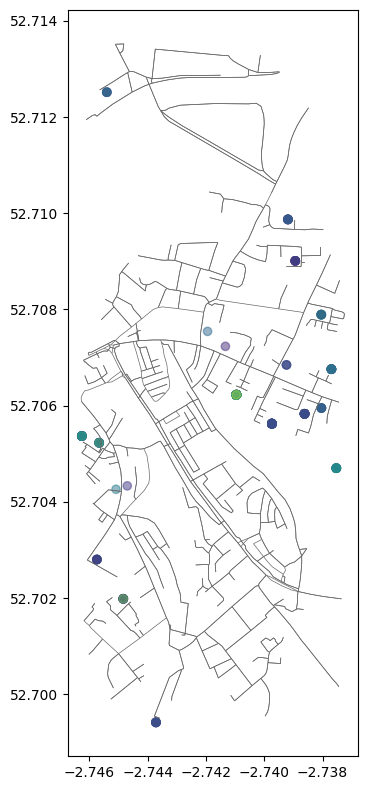

In [142]:
old_predict_price(52.7064, -2.7418, prediction_date, "F", output=3)

149 allowed type / 213 transactions
0 pois from positive_transport_amenities
0 pois from very_negative_amenities
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     36.50
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           1.24e-17
Time:                        22:40:49   Log-Likelihood:                -1829.4
No. Observations:                 149   AIC:                             3667.
Df Residuals:                     145   BIC:                             3679.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

/Users/marcus/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


mean             365404.877875
mean_se           21410.575733
mean_ci_lower    323087.740727
mean_ci_upper    407722.015023
obs_ci_lower     252951.373457
obs_ci_upper     477858.382294
Name: 0, dtype: float64

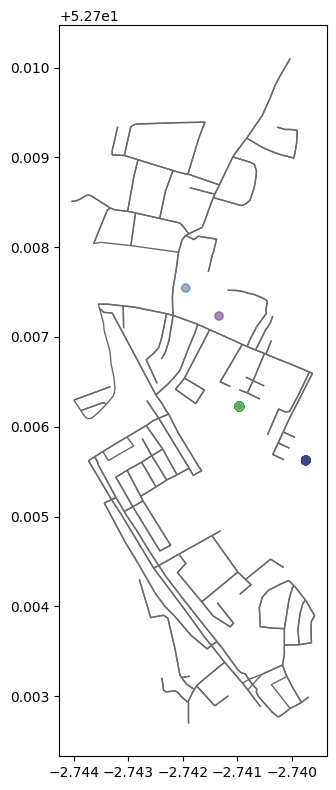

In [94]:
#Seaside apartment - before all-types
predict_price(52.7064, -2.7418, prediction_date, "F", output=3)

30 allowed type / 222 transactions
0 pois from positive_transport_amenities
0 pois from very_negative_amenities
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.092
Method:                 Least Squares   F-statistic:                    0.1835
Date:                Tue, 29 Nov 2022   Prob (F-statistic):              0.907
Time:                        15:25:38   Log-Likelihood:                -405.10
No. Observations:                  30   AIC:                             818.2
Df Residuals:                      26   BIC:                             823.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

mean             483062.482870
mean_se           40710.015192
mean_ci_lower    399381.848195
mean_ci_upper    566743.117546
obs_ci_lower      83193.698819
obs_ci_upper     882931.266922
Name: 0, dtype: float64

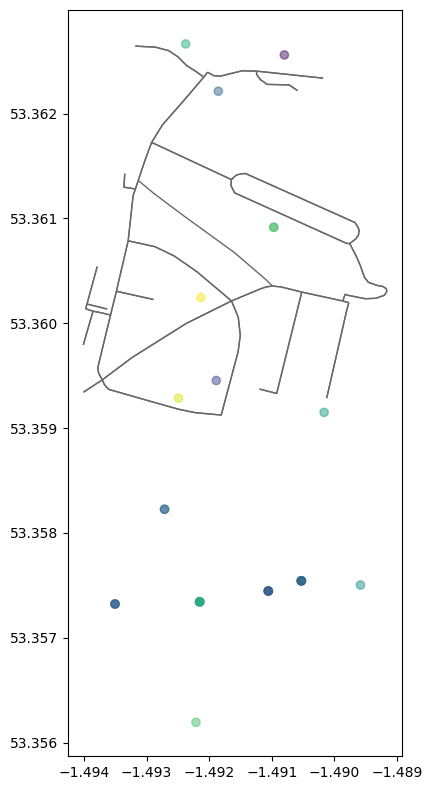

In [32]:
#Sheffield detached house
predict_price(53.3589907, -1.491815, prediction_date, "D", output=3)

70 allowed type / 95 transactions
0 pois from positive_transport_amenities
0 pois from very_negative_amenities
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     4.802
Date:                Tue, 29 Nov 2022   Prob (F-statistic):            0.00437
Time:                        15:24:03   Log-Likelihood:                -888.45
No. Observations:                  70   AIC:                             1785.
Df Residuals:                      66   BIC:                             1794.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------

mean             689588.678690
mean_se           11127.336761
mean_ci_lower    667372.234041
mean_ci_upper    711805.123338
obs_ci_lower     526273.895647
obs_ci_upper     852903.461733
Name: 0, dtype: float64

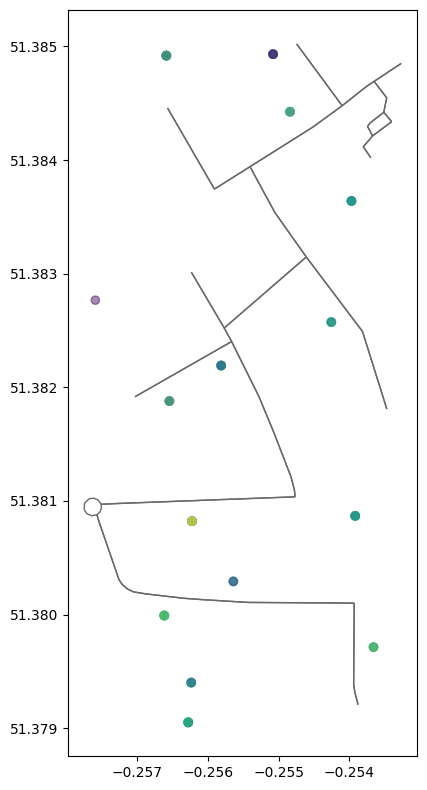

In [29]:
#Semi-detached house near london
predict_price(51.3815042, -0.2554954, prediction_date, "S", output=3)

0 allowed type / 0 transactions
growing bounding box by 25% both ways. height=0.625km width=0.625km
0 allowed type / 0 transactions
growing bounding box by 25% both ways. height=0.781km width=0.781km
0 allowed type / 0 transactions
growing bounding box by 25% both ways. height=0.977km width=0.977km
0 allowed type / 0 transactions
growing bounding box by 25% both ways. height=1.22km width=1.22km
0 allowed type / 0 transactions
growing bounding box by 25% both ways. height=1.53km width=1.53km
0 allowed type / 0 transactions
growing bounding box by 25% both ways. height=1.91km width=1.91km
0 allowed type / 0 transactions
growing bounding box by 25% both ways. height=2.38km width=2.38km
0 allowed type / 0 transactions
growing bounding box by 25% both ways. height=2.98km width=2.98km
0 allowed type / 0 transactions
growing bounding box by 25% both ways. height=3.73km width=3.73km
0 allowed type / 0 transactions
growing bounding box by 25% both ways. height=4.66km width=4.66km
0 allowed type

/Users/marcus/Library/Python/3.9/lib/python/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


mean             1.503663e+06
mean_se          7.241924e+05
mean_ci_lower   -1.345737e+05
mean_ci_upper    3.141900e+06
obs_ci_lower    -1.158410e+06
obs_ci_upper     4.165737e+06
Name: 0, dtype: float64

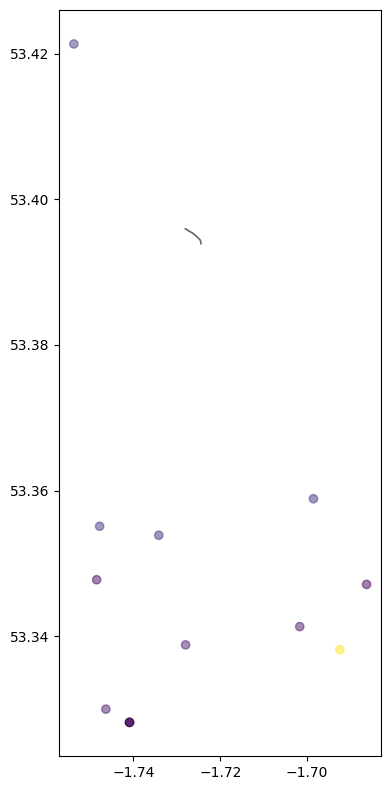

In [35]:
# Peak district other
predict_price(53.3967492, -1.7259923, prediction_date, "O", output=3)